In [ ]:
<h1 style="font-family:verdana;"> <center>📓  Carvana Image Segmentation Notebook by: The BOIS 📓</center> </h1>
<p><center style="color:#008080; font-family:cursive;"></center></p>

***

# 1.Importing libraries 📚


In [3]:
import numpy as np
import pandas as pd
import os
import skimage.io
import matplotlib.pyplot as plt
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# c = l[:(len(l))//3]

# 2.Data Pre-processing 🏋️‍♂️


# 2.1 Defining the encoding and Mask Functions 🎭

In [3]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    img = img.numpy()
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [4]:
if (False):
    l = torch.load('masks.pt',map_location=torch.device('cpu'))
    df = pd.read_csv("/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/sample_submission.csv")
    masks = []
    for k in l:
        z = k.squeeze(1)
        x = torch.split(z,1,dim=0)
        masks.append(x[0].squeeze(0))
        masks.append(x[1].squeeze(0))
    emasks = []
    for mask in masks:
        emasks.append(rle_encode(mask))
    df["rle_mask"] = emasks
    df.to_csv("submission.csv",index = False)

In [5]:
train_mask= pd.read_csv("/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/new_train_masks.csv")
test = pd.read_csv("/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/solution.csv")

In [10]:
def rle2mask(mask_rle, shape=(1280,1918)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if(pd.isna(mask_rle)):
#     if(math.isnan(mask_rle)):
        return mask_rle
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [7]:
DIR = "/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/new_train/new_train"

In [8]:
import numpy as np
from PIL import Image

image = skimage.io.imread(f"{DIR}/{train_mask.iloc[0,0]}")
print(image.shape)

mask = rle2mask(train_mask.iloc[0, 1], (image.shape[0], image.shape[1]))
mask = mask.T
print(mask.shape)

(1280, 1918, 3)
(1280, 1918)


In [9]:
mask = np.stack([mask]*3, axis=-1)
print(mask.shape)

# Apply the mask to the image
masked_image = image * mask

# Convert the result back to a PIL Image
masked_image = Image.fromarray(masked_image.astype(np.uint8))

(1280, 1918, 3)


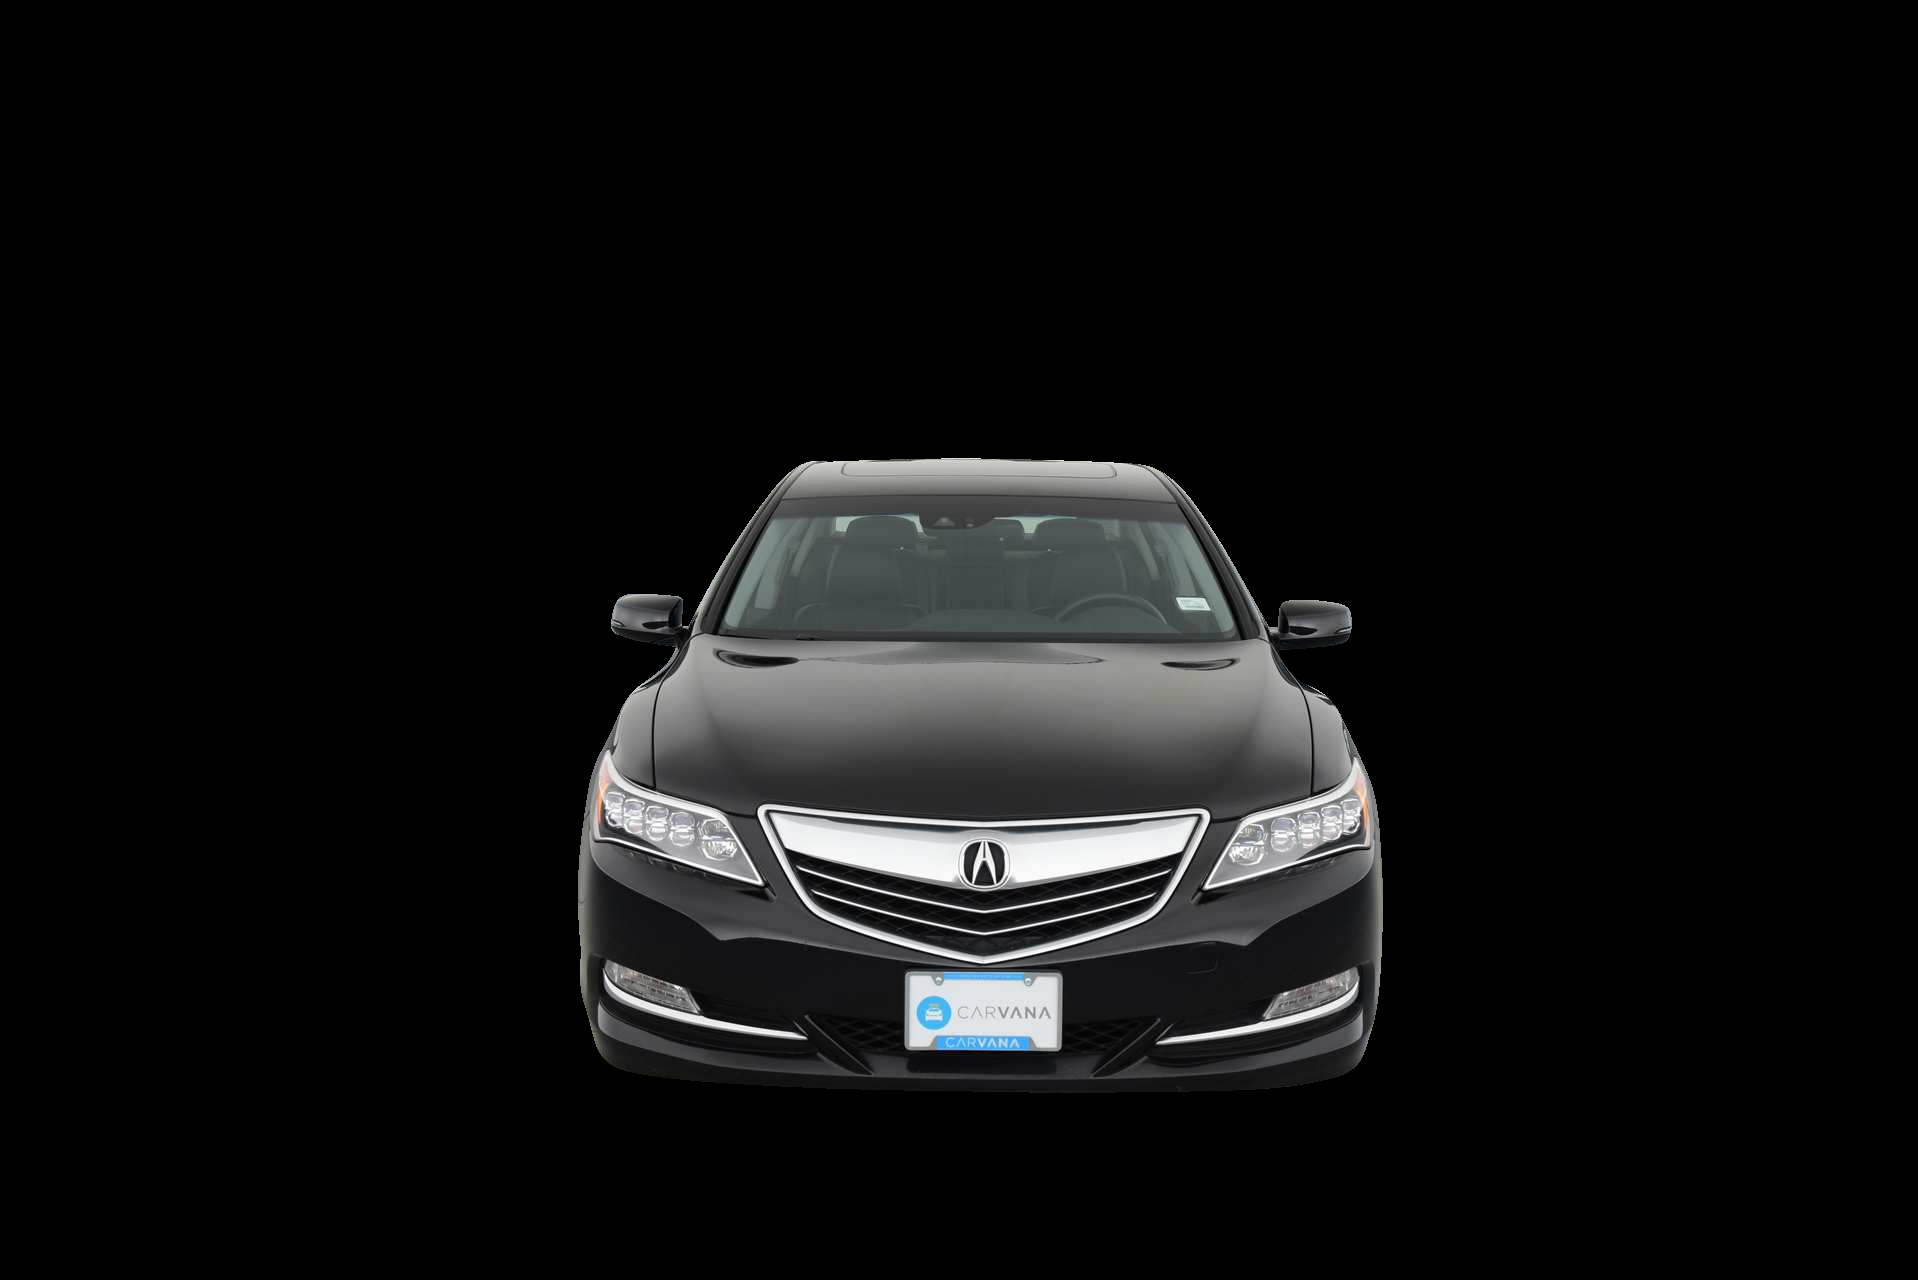

In [10]:
masked_image

# 3.Defining The Dataset Class ⇡

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage import io


In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
#         return (len(self.df)//8)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = io.imread(img_name)
        image = torch.tensor(image, dtype=torch.float32)
        image = image.permute(2,0,1)
        landmarks = self.df.iloc[idx, 1]
#         landmarks = np.array([landmarks])
#         print(landmarks)
        landmarks = rle2mask(landmarks)
        landmarks = torch.tensor(landmarks, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, landmarks.T

In [13]:
df = pd.read_csv('/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/new_train_masks.csv')
ldf = len(df)
tdf = df[:(int)(0.8*ldf)].reset_index(drop=True)
cdf = df[(int)(0.8*ldf):].reset_index(drop=True)

In [14]:
# df = pd.read_csv('/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/new_train_masks.csv')
# ldf = len(df)
# tdf = df[:(int)(ldf//8)].reset_index(drop=True)
# cdf = df[(ldf//8):(ldf//8)+(ldf//(8*8))].reset_index(drop=True)

In [15]:
ldf/(8*8)

67.5625

In [16]:
cdf

,img,rle_mask
0,ae296a20fdd9_04.jpg,581664 2 583582 2 585500 2 587418 2 589336 2 5...
1,ae296a20fdd9_05.jpg,589431 1 591349 1 593267 1 595185 1 597103 1 5...
2,ae296a20fdd9_06.jpg,591891 4 593804 14 595653 27 595720 19 597520 ...
3,ae296a20fdd9_07.jpg,588017 12 589932 18 591848 22 593695 54 593765...
4,ae296a20fdd9_08.jpg,582198 8 584113 14 586029 18 587946 20 589863 ...
...,...,...
860,db09fec614d2_16.jpg,639501 65 641388 122 643285 161 645185 54 6453...
861,dc1c5c2b9e49_01.jpg,449773 1 451690 2 453608 2 455526 2 457444 2 4...
862,dc1c5c2b9e49_02.jpg,449946 1 451863 2 453781 1 455699 1 457616 2 4...
863,dc1c5c2b9e49_03.jpg,442447 1 444364 2 446281 3 448199 2 450116 3 4...


# 3.2 Loading Dataset ↻

In [17]:
tds = CustomDataset(tdf,'/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/new_train/new_train')
cds = CustomDataset(cdf,'/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/new_train/new_train')

In [8]:
batch_size = 2
dft = pd.read_csv("/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/sample_submission.csv")
test_dir = "/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/new_test/new_test"
testset = CustomDataset(dft,test_dir)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [19]:
train_loader = torch.utils.data.DataLoader(tds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(cds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [20]:
dft

,img,rle_mask
0,dc1c5c2b9e49_05.jpg,NaN
1,dc1c5c2b9e49_06.jpg,NaN
2,dc1c5c2b9e49_07.jpg,NaN
3,dc1c5c2b9e49_08.jpg,NaN
4,dc1c5c2b9e49_09.jpg,NaN
...,...,...
759,fff9b3a5373f_12.jpg,NaN
760,fff9b3a5373f_13.jpg,NaN
761,fff9b3a5373f_14.jpg,NaN
762,fff9b3a5373f_15.jpg,NaN


In [21]:
tdf

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
...,...,...
3454,ad5a6a058944_15.jpg,921391 6 923307 13 925223 18 925315 93 927141 ...
3455,ad5a6a058944_16.jpg,925356 42 927228 122 929127 159 931031 187 932...
3456,ae296a20fdd9_01.jpg,526114 1 528031 2 529949 2 531867 2 533785 2 5...
3457,ae296a20fdd9_02.jpg,537516 1 539434 1 541352 1 543270 2 545188 2 5...


In [22]:
i,m = tds.__getitem__(1)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim


# 4. Defining The Network 🌐

In [15]:
def encoder(in_channels,size):
    x = nn.Sequential(
            nn.Conv2d(in_channels, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(size),
            nn.ReLU(inplace=True),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    return x
def decoder(out_channels,size):
    x = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(size),
            nn.ReLU(inplace=True),
            nn.Conv2d(size, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    return x

In [16]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [17]:
""" Full assembly of the parts to form the complete network """

class UNett(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNett, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.sigmoid = nn.Sigmoid()
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.sigmoid(logits)

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [18]:
import torch.nn.functional as F
class UNet2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2, self).__init__()
        self.sigmoid = nn.Sigmoid()
        # Encoder
        self.encoder1 = encoder(in_channels,64)
        self.encoder2 = encoder(64,128)

        self.center = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        
        # Decoder
        self.decoder1 = decoder(64,128)
        self.decoder2 = decoder(out_channels,64)

    def forward(self, x):
#         print(x)
        x1 = self.encoder1(x)
        x1 = self.encoder2(x1)
        
        x2 = self.center(x1)
        
        x3 = self.decoder1(x2)
        x3 = self.decoder2(x3)
        x4 = F.interpolate(x3, size=(1280,1918), mode='bilinear', align_corners=True)
        
        return self.sigmoid(x4)

In [19]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, padding=0, dilation = 1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
#         print(x)
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        x2 = F.interpolate(x2, size=(1280,1918), mode='bilinear', align_corners=True)
        return self.sigmoid(x2)


# 4.2 Dice loss calculations 🎲

In [23]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return torch.nn.BCEWithLogitsLoss(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [30]:
# def dice_loss(predicted, target):
#     smooth = 1.0
#     intersection = (predicted * target).sum()
#     return (1 - ((2.0 * intersection + smooth) / (predicted.sum() + target.sum() + smooth)))

In [21]:
def dice_loss(predicted, target):
    
#     print(predicted.shape)
    target = target.unsqueeze(1)
#     print(target.shape)
    smooth = 1e-4 # adjust this value as needed
#     predicted = torch.clamp(predicted, 0, 1) # ensure values are between 0 and 1
    target = torch.clamp(target, 0, 1) # ensure values are between 0 and 1
    intersection = (predicted * target).sum(dim=(1, 2, 3)) # sum over spatial dimensions
    return (1 - torch.mean((2.0 * intersection + smooth) / (predicted.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + smooth))) # average over batch dimension


In [32]:
from tqdm import tqdm

In [24]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet2(in_channels=3, out_channels=1).to(device)
model = UNett(3, 1).to(device)
# model = UNet(out_channels=1).to(device)
model= nn.DataParallel(model)

# criterion = bce_dice_loss
criterion = dice_coef_loss
# optimizer = optim.RMSprop(model.parameters(), lr=1e-5, momentum=0.999, foreach=True)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 4.3 Defining the training Fucntion 🚆 
* also Training the model

In [34]:
num_epochs = 10
bestScore = 1
val_losses = []
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    i = 0
    for inputs, targets in tqdm(train_loader):
        i+=1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        with autocast(dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
#         if i%10 == 0:
#             print(loss.item())
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            
    if val_loss/len(val_loader) < bestScore:
        bestScore = val_loss/len(val_loader)
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")


100%|██████████| 1730/1730 [30:03<00:00,  1.04s/it]


Epoch 1/10, Loss: 0.34203020575418636, Val Loss: 0.3301106597755027


100%|██████████| 1730/1730 [30:14<00:00,  1.05s/it]


Epoch 2/10, Loss: 0.23140932397346275, Val Loss: 0.2677976724457245


100%|██████████| 1730/1730 [30:14<00:00,  1.05s/it]


Epoch 3/10, Loss: 0.16312100601334104, Val Loss: 0.19447694226720869


100%|██████████| 1730/1730 [30:03<00:00,  1.04s/it]


Epoch 4/10, Loss: 0.11416086995532747, Val Loss: 0.22931576559780376


100%|██████████| 1730/1730 [30:20<00:00,  1.05s/it]


Epoch 5/10, Loss: 0.07873719468971209, Val Loss: 0.21997984837714848


100%|██████████| 1730/1730 [30:00<00:00,  1.04s/it]


Epoch 6/10, Loss: 0.05564947252328685, Val Loss: 0.14091334070399505


100%|██████████| 1730/1730 [29:36<00:00,  1.03s/it]


Epoch 7/10, Loss: 0.03803049301825507, Val Loss: 0.2072781785531077


100%|██████████| 1730/1730 [29:45<00:00,  1.03s/it]


Epoch 8/10, Loss: 0.026870804646111638, Val Loss: 0.15543359407927093


100%|██████████| 1730/1730 [29:47<00:00,  1.03s/it]


Epoch 9/10, Loss: 0.019155659082997052, Val Loss: 0.21674531574337366


100%|██████████| 1730/1730 [29:34<00:00,  1.03s/it]


Epoch 10/10, Loss: 0.014648003419699697, Val Loss: 0.056413040287775475


 # 4.4 Ploting The results  🖼️

In [35]:
import matplotlib.pyplot as plt
def plot(train_acc,test_acc): # plotting the line 1 points
    plt.plot([i+1 for i in range(len(train_acc))], train_acc, label = "Train")
    # plotting the line 2 points
    plt.plot([i+1 for i in range(len(test_acc))], test_acc, label = "Val")

    # naming the x axis
    plt.xlabel('epoch')
    # naming the y axis
    plt.ylabel('Score')
    # giving a title to my graph
    plt.title('Train Val / Dice Score')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()

In [36]:
x = [1-t for t in train_losses]
y = [1-v for v in  val_losses]

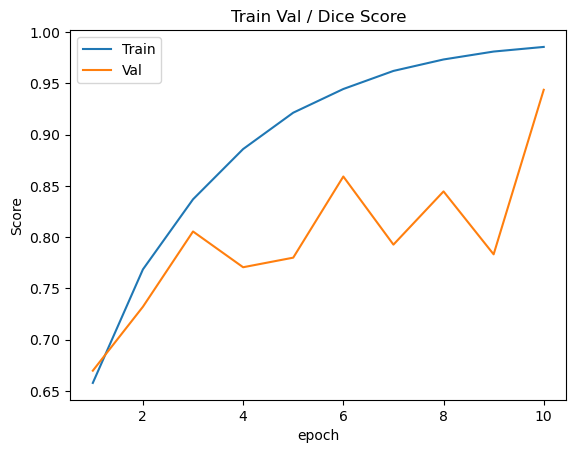

In [37]:
plot(x,y)

In [38]:
torch.save(model.state_dict(), 'model.pt')

In [39]:
torch.cuda.empty_cache()

# 5. Saving best model  💾

In [40]:
try:
    model.load_state_dict(torch.load('best_model.pt')) 
except:
    model.load_state_dict(torch.load('model.pt')) 

In [41]:
model.eval()
outputs = []
values = torch.tensor([0.0],dtype = torch.float32).to(device)
with torch.no_grad():
    for inputs, targets in tqdm(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        try:
            outputs.append((model(inputs) > 0.5).float())
#             outputs.append(torch.heaviside(model(inputs)-0.5, values))
        except:
            print("---------------")
            torch.cuda.empty_cache()
            outputs.append((model(inputs) > 0.5).float())
#             outputs.append(torch.heaviside(model(inputs)-0.5, values))

  0%|          | 0/382 [00:00<?, ?it/s]/tmp/ipykernel_28/2807508596.py:29: UserWarning: Tensor.T is deprecated on 0-D tensors. This function is the identity in these cases. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3579.)
  return image, landmarks.T
/tmp/ipykernel_28/2807508596.py:29: UserWarning: Tensor.T is deprecated on 0-D tensors. This function is the identity in these cases. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3579.)
  return image, landmarks.T
100%|██████████| 382/382 [05:19<00:00,  1.20it/s]


In [42]:
outputs3 = outputs*3

In [43]:
torch.save(outputs,"masks.pt")

In [44]:
image = skimage.io.imread(f"{test_dir}/{dft.iloc[0,0]}")
m = outputs3[0].cpu()
m = m.numpy()
m = m[0]
m = m[0]

In [45]:
m.shape

(1280, 1918)

In [46]:
def img_mask(image,mask):
    mask = np.stack([mask]*3, axis=-1)
    print(mask.shape)

    # Apply the mask to the image
    masked_image = image * mask

    # Convert the result back to a PIL Image
    masked_image = Image.fromarray(masked_image.astype(np.uint8))
    return masked_image

In [47]:
img = img_mask(image,m)

(1280, 1918, 3)


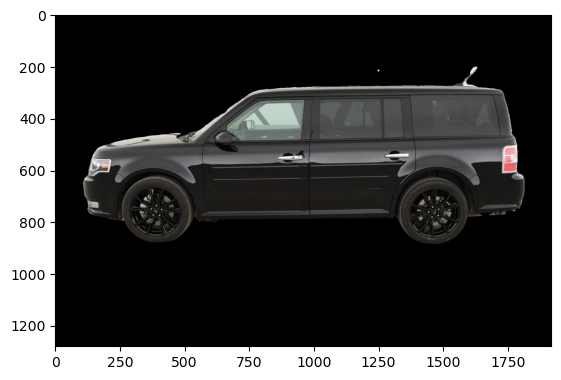

In [48]:
plt.imshow(img)

In [49]:
def rle_encode(img):
    """
    img: PyTorch tensor, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = torch.cat([torch.tensor([0]).cuda(), pixels, torch.tensor([0]).cuda()])
    runs = torch.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x.item()) for x in runs)

In [50]:
outputs[0].shape

torch.Size([2, 1, 1280, 1918])

In [51]:
if (True):
#     l = torch.load('masks.pt',map_location=torch.device('cpu'))
    df = pd.read_csv("/kaggle/input/ieeenu-cis-seniors-carvana-image-segmentation/sample_submission.csv")
    masks = []
    for k in outputs:
        z = k.squeeze(1)
        x = torch.split(z,1,dim=0)
        masks.append(x[0].squeeze(0))
        masks.append(x[1].squeeze(0))
    emasks = []
    for mask in tqdm(masks):
        emasks.append(rle_encode(mask))
    df["rle_mask"] = emasks
    df.to_csv("submission.csv",index = False)

100%|██████████| 764/764 [00:32<00:00, 23.25it/s]


# Infernece Time

In [27]:
import time

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)
img, _ = next(iter(testloader)) ## takes next batch from this dataloader which is just 1 sample
img = img.to(device)
start = time.time() ## record start time
_ = model(img)
end = time.time() ## records end time
 
print(end - start)

/tmp/ipykernel_28/2807508596.py:29: UserWarning: Tensor.T is deprecated on 0-D tensors. This function is the identity in these cases. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3579.)
  return image, landmarks.T
/tmp/ipykernel_28/2807508596.py:29: UserWarning: Tensor.T is deprecated on 0-D tensors. This function is the identity in these cases. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3579.)
  return image, landmarks.T


0.013769388198852539
